In [0]:
# importing the necessary libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

<img src="http://drive.google.com/uc?export=view&id=18q7KL4aV6McMtaid_1Let2aGkw6d4QYn" width=45%>

In [0]:
class GridWorld:
    """
    The gridwordls is a frequently used demo environment in reinforcement learning
    to try and test ideas.
    Today, we will use it to understand the concepts so far.
    
    The environment: (see image)
    * cells: the agent can step on a cell. There is exactly one cell to start from.
    This is the top left corner. There is one terminal cell where the walking ends, 
    the agent can not leave it (blue).
    * obstacles: there are cells where the agent can not step. (gray)
    * agent: it can move from one cell to an other neighboring cell. 
    Possible directions: up, down, left, right. Each transition happens with probability 1.
    * reward: after each transition the agent receives -1 point. In the terminal cell, no reward
    received anymore.
    
    Implement the environment below!
    """
    def __init__(self, size, start_cell, obstacles, terminating_state):
        self.size = size
        self.start = start_cell
        self.obstacles = obstacles
        self.termin = terminating_state
        self.current_cell = self.start
    
    def reset(self):
        # ----- reset the current cell to the start cell to start again -----
        self.current_cell = self.start

    def is_clear_from_obstacle(self, action):
        if self.current_cell[0] == 0 and action == 0: # 0 left
            return False
        if self.current_cell[1] == 0 and action == 1: # 1 up
            return False
        if self.current_cell[0] == self.size[1] and action == 2: # 2 right
            return False
        if self.current_cell[1] == self.size[0] and action == 3: # 3 down
            return False
        return True
    
    def transition(self, cell, action, boolean_prints=False):
        # ----- IMPLEMENT FUNCTION -----
        # cell = (row, column) indices
        # action: 0 left, 1 up, 2 right, 3 down
        if action == 0:
            current_cell = [cell[0], cell[1] - 1]
        elif action == 1:
            current_cell = [cell[0] - 1, cell[1]]
        elif action == 2:
            current_cell = [cell[0], cell[1] + 1]
        elif action == 3:
            current_cell = [cell[0] + 1, cell[1]]
        else:
            raise InputError('Allowed actions are; 0 (left), 1 (up), 2 (right), or 3 (down).')

        if current_cell[0] < 0:
            if boolean_prints:
                print('Not allowed to cross the border to the left!')
            current_cell = cell
        elif current_cell[1] < 0:
            if boolean_prints:
                print('Not allowed to cross the border to the top!')
            current_cell = cell
        elif current_cell[0] > (size[1] - 1):
            if boolean_prints:
                print('Not allowed to cross the border to the right!')
            current_cell = cell
        elif current_cell[1] > (size[0] - 1):
            if boolean_prints:
                print('Not allowed to cross the border to the bottom!')
            current_cell = cell
        else:
            if boolean_prints:
                print(f'Moving from {cell} to {current_cell} with {action} is a valid move.')

        for index, obstacle in enumerate(self.obstacles):
            if obstacle == (cell[0], cell[1]):
                if boolean_prints:
                    print(f'Not allowed to step on an obstacle! Obstacle index: {index}, obstacle position: {obstacle}')
                current_cell = cell

        # returns: What will be the next state
        # Take care of the borders of the grid!
        
        r_next = current_cell[0]
        c_next = current_cell[1]

        self.current_cell = (r_next, c_next)

        return (r_next, c_next)

    def reward(self, cell, action):
        # ----- RETURN REWARD -----
        # -1 if not in the terminal state
        self.transition(cell=cell, action=action)
        if self.in_terminal():
            self.current_cell = cell
            # print('Terminal state reached!')
            return 0
        else:
            self.current_cell = cell
            return -1
    
    def in_terminal(self):
        return self.current_cell == self.termin

In [0]:
class DPsolver:
    """
    This solver is based on the Bellman-equation and it is 
    solved by iteratively.
    The action-value is used to represent the utility of the 
    actions and states.
    """
    def __init__(self, gridworld, gamma_discount_factor, iterations):
        # setting parametes according to the input parameters
        self.gridworld = gridworld
        self.gamma_discount_factor = gamma_discount_factor
        self.iterations = iterations
        size = gridworld.size
        # initialize accumulaters
        self.cntr = 0
        self.sum_rewards = []
        self.path = []
        # ----- initialize the table for Q-function -----
        # A Q-table has states in the rows and actions in the columns
        self.q_table = np.zeros((4, size[0], size[1]))

    def step(self, boolean_print=False):
        """Bellman equation without action-dependent state-change probability.
        """
        # ----- WRITE THE CODE BELOW -----
        # implement one step in the value iteration
        rows, columns = self.gridworld.size  # ask for the size of the grid
        # ----- cycle over the rows -----
        for row in range(0, rows):
            # ----- cycle over the columns -----
            for column in range(0, columns):
                # ----- cycle over the actions -----
                for action in range(0, 4):
                    # ----- get the reward -----
                    reward = self.gridworld.reward(cell=(row, column), action=action)
                    # ----- calculate the corresponding next step (what would happen) -----
                    cell_next = self.gridworld.transition(cell=(row, column), action=action)
                    r2, c2 = cell_next
                    self.q_table[action, row, column] = reward + self.gamma_discount_factor * max(
                        self.q_table[0, r2, c2],
                        self.q_table[1, r2, c2],
                        self.q_table[2, r2, c2],
                        self.q_table[3, r2, c2]
                    )

        # Bellman-optimality equation for the Q function (see last equation in the 3rd theory notebook)
        # If you look closely that formula, you will see a sum over the possible next states. It is very important, you do not sum over those states.

        # increase the counter
        self.cntr += 1
        # add the return to the sum_rewards list
        self.sum_rewards.append(self.trajectory())

    def trajectory(self):
        # ----- IMPLEMENT THE FUNCTION -----
        # reset the gridworld
        self.gridworld.reset()
        
        # calculate the return along a trajectory followed by the current policy
        # when started from the start_cell
        sum_rewards = 0
    
        counter_for_trajectory = 0
        max_trajectory_iterations = self.iterations
        while not self.gridworld.in_terminal():
            best_action_index = np.argmax(a=self.q_table[:,self.gridworld.current_cell[0],self.gridworld.current_cell[1]])
            reward = self.gridworld.reward(cell=self.gridworld.current_cell, action=best_action_index)
            # ----- calculate the corresponding next step (what would happen) -----
            self.gridworld.transition(cell=self.gridworld.current_cell, action=best_action_index) 

            sum_rewards += reward
            counter_for_trajectory += 1

            if counter_for_trajectory >= max_trajectory_iterations:
                break

        return sum_rewards

    def is_learning_finished(self):
        # ----- IMPLEMENT THIS FUNCTION -----
        # check whether learning has finished, return it
        if self.cntr >= self.iterations:
            return True
        else:
            return False

In [0]:
def plot_learning_curve(ql):
    values = ql.sum_rewards
    x = list(range(len(values)))
    y = values
    plt.plot(x, y, 'ro')
    plt.show()

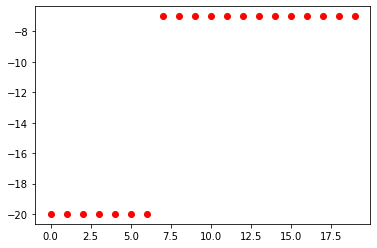

In [0]:
# grid world parameters
size = (6, 6)
start_cell = (0, 0)
obstacles = [(3, 3)]
terminating_state = (3, 5)
# q learning parameters
gamma = 0.9
# ----- What is the minimum required number of iterations? -----
iterations = 20

gw = GridWorld(size, start_cell, obstacles, terminating_state)
solver = DPsolver(gw, gamma, iterations)

while not solver.is_learning_finished():
    solver.step()

plot_learning_curve(solver)